In [57]:
from fatiando.gravmag import normal_gravity
from fatiando.vis import mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [63]:
lon, lat, height, gravity = np.loadtxt('eigen-6c4-grav-ell.gdf', skiprows=34,
                                       unpack=True)
topo = np.loadtxt('eigen-6c4-topo.gdf', skiprows=29, usecols=[-1], unpack=True)
shape = (2, 1014)

area = (lon.min(), lon.max(), lat.min(), lat.max())

ValueError: need more than 3 values to unpack

In [3]:
# First, lets calculate the gravity disturbance (e.g., the free-air anomaly)
# We'll do this using the closed form of the normal gravity for the WGS84
# ellipsoid
gamma = normal_gravity.gamma_closed_form(lat, height)
disturbance = gravity - gamma

In [4]:
# Now we can remove the effect of the Bouguer plate to obtain the Bouguer
# anomaly. We'll use the standard densities of 2.67 g.cm^-3 for crust and 1.04
# g.cm^-3 for water.
bouguer = disturbance - normal_gravity.bouguer_plate(topo)

In [5]:
topo_positive = topo[topo >= 0]
topo_negative = topo[topo < 0]

In [6]:
jacobian = np.zeros([len(bouguer),2])
jacobian[topo < 0, 0] = topo_negative
jacobian[topo >= 0, 1] = topo_positive

In [9]:
y = bouguer

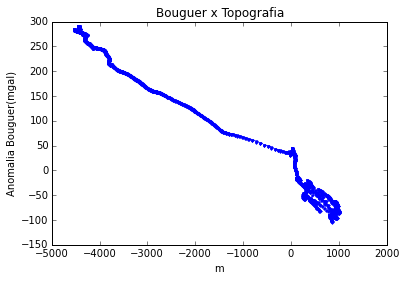

In [59]:
plt.figure()
plt.plot(topo,bouguer,'.')
plt.title('Bouguer x Topografia')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')

### Cálculo do parâmetro por mínimos quadrados

In [10]:
a_est = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),jacobian)),jacobian.transpose()),y)
print('a estimado=',a_est)

('a estimado=', array([-0.06103923, -0.08953672]))


### Cálculo do parâmetro por mínimos quadrados reponderado

In [11]:
aest=a_est

In [30]:
weight = np.zeros([len(y),len(y)])
np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [31]:
aest=np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
print('a estimado reponderado',aest)

('a estimado reponderado', array([-0.06079881, -0.08801506]))


In [ ]:
[-0.06102272, -0.08952045]
[-0.06097439, -0.08935179]
[-0.06093841, -0.08907973]
[-0.06092419, -0.08882681]
[-0.06089398, -0.08867685]
[-0.06086313, -0.08852446]
[-0.06084527, -0.08835634]
[-0.06082297, -0.08823997]
[-0.06080771, -0.08809011]
[-0.06079881, -0.08801506]

In [61]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [62]:
result

[array([-0.06103923, -0.08953672]),
 array([-0.06102272, -0.08952045]),
 array([-0.06097439, -0.08935179]),
 array([-0.06093841, -0.08907973]),
 array([-0.06092419, -0.08882681]),
 array([-0.06089398, -0.08867685]),
 array([-0.06086313, -0.08852446]),
 array([-0.06084527, -0.08835634]),
 array([-0.06082297, -0.08823997]),
 array([-0.06080771, -0.08809011])]